This is an example code for conducting trend analysis used in Sobel et al. (2023) PNAS paper. We use SST from Hadley SST as an example, but one can swap the data with SST or track density from CMIP6 or HighResMIP.

### 0. Python Packages & functions:

- Functions for trend analysis which were by Naomi Henderson for Seager et al. (2019, 2022)

In [1]:
import os
import numpy as np
import xarray as xr
from scipy import stats
import subprocess
import xesmf as xe
import gcsfs
import sys
import warnings
warnings.filterwarnings("ignore")

In [2]:
def linregress_1d(x, y):
        # Wrapper around scipy linregress to use in apply_ufunc
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        return np.array([slope, intercept, r_value, p_value, std_err])
def linregress_xr(da,dim='time'):
        NT = len(da[dim])
        da[dim] = np.arange(0,NT)
        stats = xr.apply_ufunc(linregress_1d, da[dim], da,
        input_core_dims=[[dim], [dim]],
        output_core_dims=[["parameter"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=['float32'],
        output_sizes={"parameter": 5},
        )
        ds = ((NT-1)*stats[:,:,0]).to_dataset(name='trend')
        ds['pvalue'] = stats[:,:,3]
        return ds


- Functionsfor making plots by Chia-Ying Lee

In [3]:
import matplotlib.pyplot as plt
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def plotMap_myproj(MyFigsize,MyFontsize,londis,latdis,lon1,lon2,lat1,lat2,map_proj=ccrs.PlateCarree(central_longitude=180)):
        """
        map_proj = ccrs.PlateCarree(central_longitude=180)
        data_crs = ccrs.PlateCarree()
        ax.plot(iblon[:,iSlandfall[0]],iblat[:,iSlandfall[0]],transform=ccrs.PlateCarree())
        note that the logitude and latitude here can only be from -180 to 180
        """

        if ((lon1 >=180) & (lon2 >180)):
                lon1 = lon1-360
                lon2 = lon2-360
        fig = plt.figure(figsize=MyFigsize)
        ax = fig.add_subplot(
                1, 1, 1,
                projection=map_proj)
        ax.coastlines(resolution='110m')
        gl = ax.gridlines(draw_labels=True,
                linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.xlocator = mticker.FixedLocator(np.arange(-180,185,londis))
        gl.ylocator = mticker.FixedLocator(range(-90, 90,latdis))
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        ax.add_feature(cart.feature.BORDERS)
        ax.set_extent([lon1,lon2,lat1,lat2],crs = ccrs.PlateCarree())
        return fig,ax

def plot_TP(ds, name,fignum):
        alpha = 0.5
        interval = 5
        lon1, lon2 = 10,350
        lat1, lat2 = -60, 60
        xlong = np.arange(lon1,lon2+interval,interval)
        xlat = np.arange(lat1,lat2+interval,interval)
        MyFigsize,MyFontsize = (6.5,4),8
        londis, latdis = 30, 15
        my_proj = ccrs.PlateCarree(central_longitude=180)
        data_ccrs = ccrs.PlateCarree()
        fig,ax = plotMap_myproj(MyFigsize,MyFontsize,londis,latdis,lon1,lon2,lat1,lat2,my_proj)
        cm = plt.get_cmap("RdYlBu_r")
        an_image = ds.trend.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(),
                vmin=-1.5, vmax=1.5, cmap=cm, add_colorbar=False, rasterized=True);
        cbar = plt.colorbar(an_image, shrink=0.5, pad=.03)
        #cbar.set_label(r'SST trend anomaly ($\degree C$)')
        cbar.ax.tick_params(labelsize=6)

        CS = ds.trend.plot.contour(ax=ax, transform=ccrs.PlateCarree(),vmin=-2,vmax=2,colors='k',levels=21)
        ax.clabel(CS, inline=1, fontsize=8, fmt='%1.1f')
        ax.add_feature(cfeature.LAND, zorder=5, color='lightgrey', edgecolor='black', alpha=1.0)

        ds.pvalue.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), levels=[alpha,1.0],colors='none',hatches=['..',None],extend='both',add_colorbar=0)
        ax.coastlines(linewidth=2,zorder=6);

        fig.text(0.1,0.75,fignum,fontsize=10)
        ax.set_extent((120, 290, -30, 30), crs=ccrs.PlateCarree())
        title = name
        name1 = name.replace(' ','_')
        plt.title(f'{title}',fontsize=10,pad=10);
        plt.savefig(f'{name1}_trend.png',dpi=300)
        return()


### 1.  Trend analysis

In [4]:
### set up data format
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-30.5,31, 1)),
        'lon': (['lon'], np.arange(120.5,290,1)),})
encoding={'ts':{'dtype':'float32'},'lon':{'dtype':'float32'},'lat':{'dtype':'float32'}}


In [5]:
### These must all be monthly datasets!!
y_start = 1958
y_end = 2014
#obs
ds = xr.open_dataset('HadISST_Sobel_etal_2023PNAS.nc')
obs_start = np.nanmax([y_start,ds.time[0].dt.year.values.tolist()])
obs_end = np.min([y_end,ds.time[-1].dt.year.values.tolist()])
ds = ds.sel(time=slice(str(obs_start)+'-01',str(obs_end)+'-12')).coarsen(time=12,boundary='trim').mean()
regridder = xe.Regridder(ds, ds_out, 'bilinear', periodic=False)
dsr = regridder(ds)
ds_stats = linregress_xr(dsr.ts)
ds_stats.to_netcdf('HadISST_trend.nc')

()

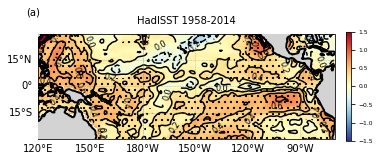

In [6]:
plot_TP(ds_stats,'HadISST' +' '+str(obs_start)+'-'+str(obs_end),'(a)')

### 2. Code for calculating scatter plot data. 
- It written by Naomi Henderson for Seager et al. (2019, 2022), modified by Chia-Ying Lee

In [7]:
# PC and RMSE
xE = 140; xW = 270;
yN = 10; yS = -10;

# NS index - CHANGED
xNS_W = 190; xNS_E = 240;
yNS_N = 9; yNS_Eq = 3; 

# EW index
xEW_W1 = 140; xEW_E1 = 170; 
xEW_W2 = 190; xEW_E2 = 270; 
yWE = 3;

In [8]:
### the reference data
dsHad = xr.open_dataset('HadISST_trend.nc').sel(lon= slice(xE,xW),lat=slice(yS,yN))
y = dsHad.trend
print(dsHad.trend.sel(lon=slice(xNS_W,xNS_E),lat=slice(-yNS_N,-yNS_Eq)).mean(['lon','lat']))
ymean = y.mean(['lat','lon'])
ynorm = np.sqrt(((y - ymean)**2).mean(['lat','lon']))
vol = np.sqrt((0*y + 1).mean(['lat','lon']))


<xarray.DataArray 'trend' ()>
array(0.30255857, dtype=float32)


In [9]:
###  data for comparing to the reference data. Here we use same HadISST_trend data
name = 'HadISST'
rows=[]
ds = xr.open_dataset('HadISST_trend.nc').sel(lon= slice(xE,xW),lat=slice(yS,yN))
x = ds.trend + 0*dsHad.trend
xmean = x.mean(['lat','lon'])
xnorm = np.sqrt(((x - xmean)**2).mean(['lat','lon']))
xycorr = ((x-xmean) * (y-ymean)).mean(['lat','lon'])
PCC = (xycorr/xnorm/ynorm) 
RMS = np.sqrt(((x - y)**2).mean(['lat','lon']))/vol
dsS = ds.sel(lon=slice(xNS_W,xNS_E),lat=slice(-yNS_N,-yNS_Eq)).mean(['lon','lat'])
dsN = ds.sel(lon=slice(xNS_W,xNS_E),lat=slice( yNS_Eq, yNS_N)).mean(['lon','lat'])
dsEQ = ds.sel(lon=slice(xNS_W,xNS_E),lat=slice(-yNS_Eq, yNS_Eq)).mean(['lon','lat'])
CE_index = (0.5*(dsS + dsN) - dsEQ).trend.item()
dsW = ds.sel(lon= slice(xEW_W1,xEW_E1),lat=slice(-yWE,yWE)).mean(['lon','lat'])
dsE = ds.sel(lon= slice(xEW_W2,xEW_E2),lat=slice(-yWE,yWE)).mean(['lon','lat'])
EW_index = -(dsE-dsW).trend.item()
print(name,dsS.trend.values)

rows += [[name,float(xmean.values),float(RMS.values),float(PCC.values),CE_index,EW_index]]
print (rows)

HadISST 0.30255857
[['HadISST', 0.2876518964767456, 0.0, 1.0000001192092896, 0.2386957525741309, 0.363864541053772]]


### 3. Reference
- Seager, R., N. Henderson, and M. Cane, 2022: Persistent Discrepancies between Observed and Modeled Trends in the Tropical Pacific Ocean. J. Climate, 35, 4571–4584, https://doi.org/10.1175/JCLI-D-21-0648.1.
- Seager, R., Cane, M., Henderson, N. et al. Strengthening tropical Pacific zonal sea surface temperature gradient consistent with rising greenhouse gases. Nat. Clim. Chang. 9, 517–522 (2019). https://doi.org/10.1038/s41558-019-0505-x
